# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

**План работ**

1. Загрузить данные и изучить их.
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры. Кратко описать выводы исследования.
4. Проверить качество лучшей модели на тестовой выборке.
5. Дополнительное задание: проверить модели на вменяемость.

## Загрузка и первичное изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [5]:
data['is_ultra'].value_counts()  # оценим сбалансированность данных

0    2229
1     985
Name: is_ultra, dtype: int64

In [6]:
data['is_ultra'].mean()  # доля пользователей тарифа ultra

0.30647168637212197

**Присутствует явная несбалансированность классов в данных**: количество пользователей тарифа smart более чем в 2 раза превышается количество пользователей ultra (пользователи ultra составляют только 30 процентов всей выборки). Это вполне объяснимо, так как ultra более дорогой тариф с большим количеством минут, мегабайт интернета и смс. Большинству пользователей просто не нужно такое количество и они не переплачивают.

## Разбиение данные на выборки

In [7]:
# отделим целевой признак от остальных признаков

features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

In [8]:
features.info()  # проверим, что выборка разделена корректно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
dtypes: float64(4)
memory usage: 100.6 KB


In [9]:
target.head(5)

0    0
1    0
2    0
3    1
4    0
Name: is_ultra, dtype: int64

In [10]:
# разделим данные на обучающую, валидационную и тестовую выборки

features_train, features_val_test, target_train, target_val_test = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_val_test, target_val_test, test_size=0.5, random_state=42, stratify=target_val_test)

In [11]:
# проверим размеры выборок, а также то, что изначальное распределение классов сохранилось

display(features_train.shape, target_train.shape)
display(features_valid.shape, target_valid.shape)
display(features_test.shape, target_test.shape)
display(target_train.mean())

(1928, 4)

(1928,)

(643, 4)

(643,)

(643, 4)

(643,)

0.3065352697095436

## Исследование моделей

### Дерево решений

In [12]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
train_results = []
valid_results = []
for depth in range(1, 6):
    # инициализация модели с заданной максимальной глубиной дерева
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_train, target_train) # обучение модели
    train_results.append(model.score(features_train, target_train))
    result = model.score(features_valid, target_valid) # качество модели на валидационной выборке
    valid_results.append(result)
    if result > best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth_tree = depth

In [13]:
display(best_result_tree) # лучший результат accuracy модели
display(best_depth_tree) # глубина дерева у лучшей модели

0.8040435458786936

3

**Визуализация зависимости качества от изменения гиперпараметров**

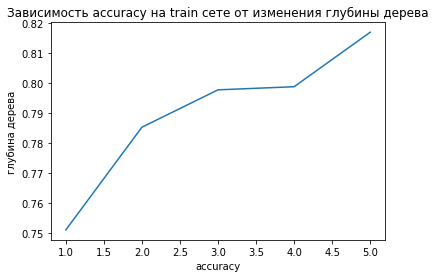

In [14]:
plt.plot(range(1, 6), train_results)
plt.title("Зависимость accuracy на train сете от изменения глубины дерева")
plt.xlabel("accuracy")
plt.ylabel("глубина дерева")
plt.show()

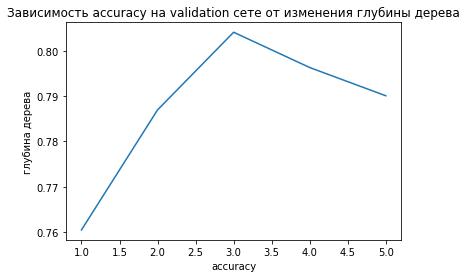

In [15]:
plt.plot(range(1, 6), valid_results)
plt.title("Зависимость accuracy на validation сете от изменения глубины дерева")
plt.xlabel("accuracy")
plt.ylabel("глубина дерева")
plt.show()

**На графика видно, что при грубине дерева больше 3, accuracy на обучающей выборке продолжает расти, а на валидационной начинает падать.** Это говорит о том, что при большей глубине модель начинает переобучаться.

**Визуализация дерева решений лучшей модели**

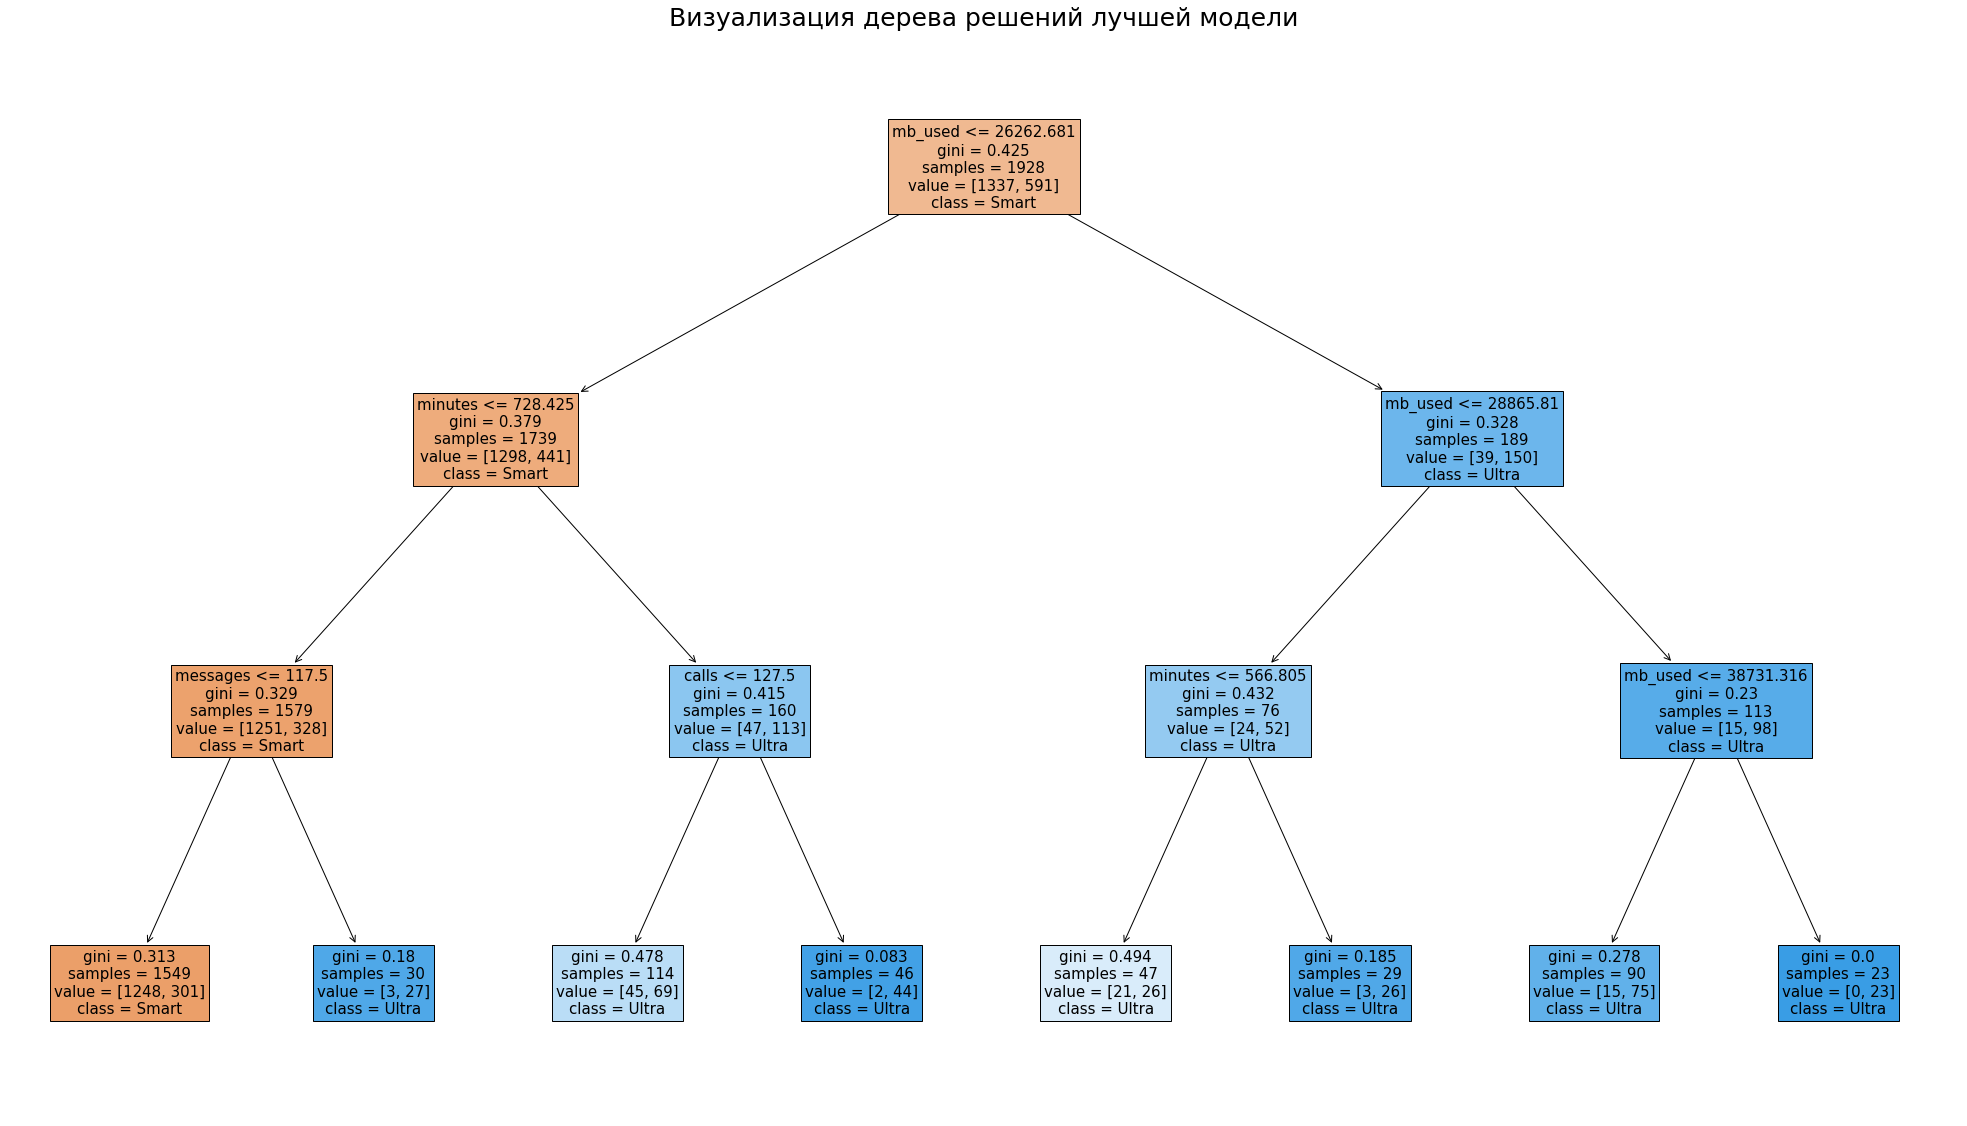

In [16]:
fig = plt.figure(figsize=(35,20))
_ = plot_tree(best_model_tree, 
               feature_names=features.columns.values, 
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15)
plt.title("Визуализация дерева решений лучшей модели", fontsize=25)
plt.show()

**Выводы по дереву решений:**

Модель использует все признаки для принятия решений. Чаще всего разбиение идет по количеству потраченных мегабайт (в 3 узлах из 7). 

В целом, логика модели понятна: если пользователь пользуется всеми услугами в небольших количества, то ему подходит тариф smart. Если же какой-то определенный параметр выбивается и имеет высокое значение, например минуты или смс, такому пользователю нужен тариф с расширенными пакетами, то есть ultra.

### Случайный лес

In [17]:
# объединенная выборка из train и validation
features_train_val = pd.concat([features_train, features_valid], ignore_index=True)
target_train_val = pd.concat([target_train, target_valid], ignore_index=True)

In [18]:
features_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2571 entries, 0 to 2570
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     2571 non-null   float64
 1   minutes   2571 non-null   float64
 2   messages  2571 non-null   float64
 3   mb_used   2571 non-null   float64
dtypes: float64(4)
memory usage: 80.5 KB


In [19]:
features_train_val.head()

,calls,minutes,messages,mb_used
0,82.0,629.14,29.0,15475.25
1,35.0,280.77,52.0,15578.67
2,47.0,266.14,82.0,25562.28
3,99.0,642.81,45.0,10187.06
4,73.0,476.81,90.0,13738.12


**Подбор параметров и обучение с GridSearchCV**

In [20]:
%%time

parametrs = { 'n_estimators': range(10, 61, 10),
              'max_depth': range(1, 13) }

model = RandomForestClassifier(random_state=42)
grid = GridSearchCV(model, parametrs)
grid.fit(features_train_val, target_train_val)

best_model_forest = grid.best_estimator_
best_result_forest = grid.best_score_
best_parametrs_forest = grid.best_params_

CPU times: user 50.1 s, sys: 503 ms, total: 50.6 s
Wall time: 54.6 s


In [21]:
display(best_result_forest) # лучший результат модели
display(best_parametrs_forest) # лучшие параметры модели

0.8074640172263987

{'max_depth': 9, 'n_estimators': 50}

**Стандартный перебор параметров в цикле и обучение**

In [22]:
best_model_forest_stand = None
best_result_forest_stand = 0
best_est_forest = 0
best_depth_forest = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        # инициализация модели с заданным количеством деревьев и максимальной глубиной дерева
        model = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) # обучение модели
        result = model.score(features_valid, target_valid) # качество модели на валидационной выборке
        if result > best_result_forest_stand:
            best_model_forest_stand = model
            best_result_forest_stand = result
            best_est_forest = est
            best_depth_forest = depth

In [23]:
display(best_result_forest_stand) # лучший результат accuracy модели
display(best_est_forest) # количество деревьев
display(best_depth_forest) # глубина дерева у лучшей модели

0.8118195956454122

50

5

### Логистическая регрессия

In [24]:
best_model_log_reg = None
best_result_log_reg = 0
best_iter_log_reg = 0
for i in range (1000, 3001, 100):
    # инициализация модели с заданным максимальным количеством итераций
    model = LogisticRegression(random_state=42, solver='lbfgs', max_iter=i)
    model.fit(features_train, target_train) # обучение модели
    result = model.score(features_valid, target_valid) # качество модели на валидационной выборке
    if result > best_result_log_reg:
        best_model_log_reg = model
        best_result_log_reg = result
        best_iter_log_reg = i

In [25]:
display(best_result_log_reg) # лучший результат accuracy модели
display(best_iter_log_reg) # количество интераций

0.7045101088646968

1000

### Вывод

Мы рассмотрели 3 модели: дерево решений, случайный лес и логистическую регрессию. У каждой мы попробовали различные гиперпараметры. По результатам исследования самое высокое значение accuracy (0.81) на валидационной выборке мы получили для модели случайного леса с 30 деревьями и максимальной глубиной дерева равной 9. 

## Проверка модель на тестовой выборке

На валидационной выборке лучший результат показала **модель случайного леса со следующими гиперпараметрами: максимальная глубина дерева – 9, количество деревьев – 50**. Поэтому ее и будем проверять на тестовой выборке.

In [26]:
model = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=9)
model.fit(features_train_val, target_train_val) # обучение модели на объединенной выборке из train и validation
model.score(features_test, target_test)

0.8195956454121306

**Вывод**

На тестовой выборке выбранная модель показала результат accuracy равный 0.82.

## Проверка модели на адекватность

In [27]:
# модель "угадайка", которая с равной вероятностью возвращает какой-то класс из представленных в таргете
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=1)  
dummy_clf.fit(features_train_val, target_train_val)
dummy_clf.score(features_test, target_test)

0.6936236391912908

**Вывод:** Можно сказать, что наша модель работает адекватно, так как ее качество действительно сильно превышает наивную модель, которая просто наугад выдает результат того или иного класса.

## Дополнительные метрики

In [28]:
predictions = model.predict(features_test)

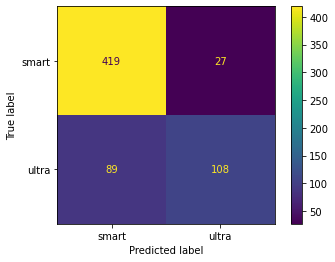

In [29]:
# матрица ошибок
cm = confusion_matrix(target_test, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=['smart', 'ultra']).plot()

In [30]:
# метрики модели
print(classification_report(target_test, predictions, target_names=['smart', 'ultra']))

              precision    recall  f1-score   support

       smart       0.82      0.94      0.88       446
       ultra       0.80      0.55      0.65       197

    accuracy                           0.82       643
   macro avg       0.81      0.74      0.76       643
weighted avg       0.82      0.82      0.81       643



**Вывод**

Из матрицы ошибок видно, что модель лучше справляется с предсказание тарифа smart. Таблица с метриками это также подтверждает. F1-мера для smart значительно выше, чем для ultra, хотя, в целом, 0.65 – это не самое низкое значение. Однако, на такие результаты могла повлиять несбалансированность обучающей выборки: примеров для тарифа smart в 2 раза больше, чем для тарифа ultra.

Учитывая все вышеупомянутое, macro усреднение F1-меры все равно дает значение выше 0.75, что может говорить о достаточно высоком качестве работы модели, а также об адекватности нашего изначального выбора и оценки модели только по accuracy.

## Общий вывод по проекту

**В проекте велась работа с данными о поведении клиентов, пользующихся 2 разными тарифами.** Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Были даны следующие параметры:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Данные были заранее обработаны: очищены от дубликатов, пропусков и прочих ошибок. Для дальнейшей работы они были разделены на 3 выборки: обучающую, валидационную и тестовую.

**Задача состояла в подборе наилучшей по качеству модели для рекомендации нового тарифа пользователю на основе его поведения в течение месяца.** 

Мы попробовали 3 различные модели: дерево решений, случайный лес и логистическую регрессию. У каждой модели мы также меняли гиперпараметры, чтобы добиться наиболее высокой оценки качества. **По результатам экспериментов на валидационной выборке лучший результат показала модель случайного леса со следующими гиперпараметрами: максимальная глубина дерева – 9, количество деревьев – 50.**

Затем модель с данными параметрами была обучена на объединенной выборке из обучающей и валидационной, чтобы попробовать дополнительно увеличить качество, а затем проверена на тестовой выборке. 

**В результате итоговое качество на тестовой выборке составляет 0.82.**